In [1]:
from utils import *

print_info()

Last run on: 2018-03-21
PyTorch version: 0.3.1.post2
fastai version: 0.6


https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb

### Data
[original website - unreliable](http://host.robots.ox.ac.uk/pascal/VOC/)

[faster mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/)

[json annotations](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip)

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

In [4]:
# Ensure files have been downloaded to <PATH>
PATH = Path('data/pascal/2007')

In [5]:
list(PATH.iterdir())

[PosixPath('data/pascal/2007/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/2007/VOCdevkit'),
 PosixPath('data/pascal/2007/PASCAL_VOC.zip'),
 PosixPath('data/pascal/2007/VOCtest_06-Nov-2007.tar'),
 PosixPath('data/pascal/2007/PASCAL_VOC')]

In [6]:
%ls

cats_vs_dogs_pretrained.ipynb                 mnist_fully_connected.ipynb
cifar10_evaluation_of_cosine_annealing.ipynb  pascal_voc2007_from_scratch.ipynb
cifar10_resnet20_from_scratch.ipynb           __pycache__/
data/                                         README.md
dogs_vs_cats_CAM.ipynb                        resnet.py
fastai@                                       utils.py
mnist_fully_connected_from_paths.ipynb


In [7]:
# !tar -xf {list(PATH.iterdir())[0]} -C {PATH}
# !unzip {PATH}/PASCAL_VOC.zip -d {PATH}

In [8]:
trn_j = json.load((PATH/'PASCAL_VOC/pascal_train2007.json').open())

In [9]:
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [10]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [11]:
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [12]:
trn_j[CATEGORIES][:3]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'}]

In [13]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'

In [14]:
cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
list(cats.items())[:5]

[(1, 'aeroplane'), (2, 'bicycle'), (3, 'bird'), (4, 'boat'), (5, 'bottle')]

In [15]:
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
list(trn_fns.items())[:5]

[(12, '000012.jpg'),
 (17, '000017.jpg'),
 (23, '000023.jpg'),
 (26, '000026.jpg'),
 (32, '000032.jpg')]

In [16]:
trn_ids = [o[ID] for o in trn_j[IMAGES]]
trn_ids[:5]

[12, 17, 23, 26, 32]

In [17]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('data/pascal/2007/VOCdevkit/VOC2007/Annotations'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/JPEGImages')]

In [18]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [19]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/2007/VOCdevkit/VOC2007/JPEGImages/001785.jpg'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/JPEGImages/000850.jpg'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/JPEGImages/001724.jpg'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/JPEGImages/003223.jpg'),
 PosixPath('data/pascal/2007/VOCdevkit/VOC2007/JPEGImages/005674.jpg')]

We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

In [20]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

2501

In [21]:
list(trn_anno.items())[:3]

[(12, [(array([ 96, 155, 269, 350]), 7)]),
 (17, [(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]),
 (23,
  [(array([229,   8, 499, 244]), 2),
   (array([219, 229, 499, 333]), 2),
   (array([  0,   1, 368, 116]), 15),
   (array([  1,   2, 461, 242]), 15),
   (array([  0, 224, 485, 333]), 15)])]

Some libs take VOC format bounding boxes, so this let's us convert back when required:

In [22]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [23]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [24]:
bb_hw(trn_anno[12][0][0])

array([155,  96, 195, 173])

In [25]:
trn_j[IMAGES][:3]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334}]

In [26]:
im = open_image(PATH/'VOCdevkit'/'VOC2007'/'JPEGImages'/trn_j[IMAGES][0][FILE_NAME])

In [27]:
im.shape

(333, 500, 3)

In [28]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

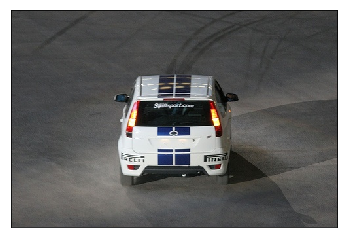

In [29]:
show_img(im)

In [30]:
from IPython.core.debugger import set_trace

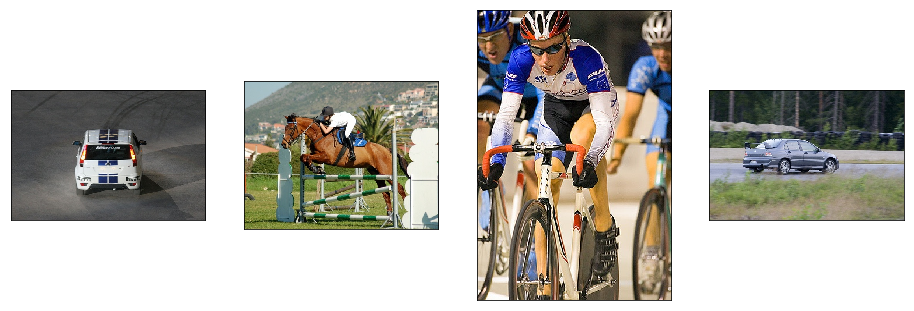

In [46]:
fig, axes = plt.subplots(1, 4, figsize=(16, 10))
imgs = [open_image(PATH/'VOCdevkit'/'VOC2007'/'JPEGImages'/trn_j[IMAGES][i][FILE_NAME]) for i in range(4)]

for img, ax in zip(imgs, axes.reshape(-1)):
    show_img(img, ax=ax)

A simple but rarely used trick to making text visible regardless of background is to use white text with black outline, or visa versa. Here's how to do it in matplotlib.

In [48]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [62]:
trn_j[IMAGES][6]

{'file_name': '000034.jpg', 'height': 500, 'id': 34, 'width': 360}

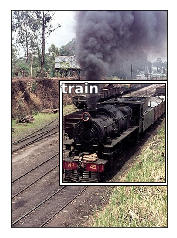

In [77]:
im = trn_j[IMAGES][6]
ary = open_image(IMG_PATH/im[FILE_NAME])
ax = show_img(ary)

anno = trn_anno[im[ID]]
b = bb_hw(anno[0][0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[anno[0][1]])

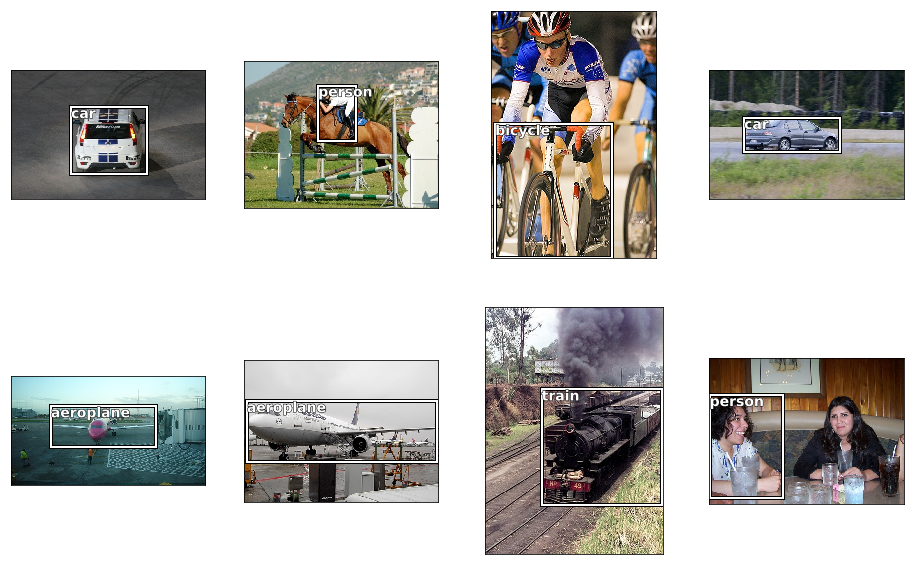

In [80]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
imgs = [trn_j[IMAGES][i] for i in range(8)]

for im, ax in zip(imgs, axes.reshape(-1)):
    ary = open_image(IMG_PATH/im[FILE_NAME])
    ax = show_img(ary, ax=ax)

    anno = trn_anno[im[ID]]
    b = bb_hw(anno[0][0])
    draw_rect(ax, b)
    draw_text(ax, b[:2], cats[anno[0][1]])